# ***Multi-model Financial Fraud classification***


---



# **Import the Libraries**

In [ ]:
# Importing libraries for data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Importing libraries for machine learning / computations
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, precision_score, recall_score, f1_score, accuracy_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
import xgboost as xgb
import time
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

# **Synthetic Dataset Creation**
This notebook will generate a synthetic dataset containing 100,000 records with a 0.02% fraud rate.

In [ ]:
def generate_fraud_dataset(n_samples=100000, fraud_rate=0.02):
    #73 for reproductibility
    np.random.seed(73)

    #merchant types, added unknown as common "catch all" in financial institutions
    merchant_types = ['Grocery', 'Gas', 'Restaurant', 'Online', 'ATM', 'Retail', 'Pharmacy', 'Entertainment', 'Unknown']

    #city options
    cities = ["New York, USA", "Los Angeles, USA", "London, UK", "Sydney, Australia", "Toronto, Canada", "Berlin, Germany", "Tokyo, Japan", "Chapel Hill, USA", "Miami, USA"]

    #empty to load data
    data = []
    now = datetime.now()

    #number of fraud and normal items based on parameters
    n_fraud = int(n_samples * fraud_rate)
    n_normal = n_samples - n_fraud

    #define timestamp
    def random_timestamp():
        delta_days = np.random.randint(0, 365)
        delta_seconds = np.random.randint(0, 86400)
        return now - timedelta(days=delta_days, seconds=delta_seconds)

    #for loop for 'normal' transactions
    for i in range(n_normal):
        merchant_type = np.random.choice(merchant_types)
        #city probability (mostly local for normal)
        city = np.random.choice(cities, p=[0.05, 0.05, 0.03, 0.01, 0.03, 0.01, 0.01, 0.75, 0.06])
        #iniate timestamp
        timestamp = random_timestamp()
        #make sure account cannot be younger than transaction
        max_age_days = min(3650, (timestamp - datetime(timestamp.year - 10, 1, 1)).days)
        account_created = (timestamp - timedelta(days=np.random.randint(1, max_age_days))).date()

        #randomized amount per vendor type
        if merchant_type == 'Grocery':
            amount = np.random.gamma(2, 25) + 10
        elif merchant_type == 'Gas':
            amount = np.random.normal(50, 20)
        elif merchant_type == 'Restaurant':
            amount = np.random.exponential(30) + 15
        elif merchant_type == 'Online':
            amount = np.random.lognormal(3, 1)
        elif merchant_type == 'ATM':
            amount = np.random.choice([20, 40, 60, 80, 100, 200])
        elif merchant_type == 'Retail':
            amount = np.random.gamma(1.5, 40)
        elif merchant_type == 'Pharmacy':
            amount = np.random.gamma(1.2, 15) + 5
        elif merchant_type == 'Entertainment':
            amount = np.random.exponential(30) + 15
        else:
            amount = np.random.gamma(2, 30) + 20

        #append transaction data
        transaction = {
            'transaction_id': f'TXN{i:06d}',
            'timestamp': random_timestamp(),
            'amount': round(max(amount, 1.0), 2),
            'merchant_type': merchant_type,
            'location': city,
            'account_number': f"AC{np.random.randint(10**9, 10**10)}",
            'account_created': account_created,
            'prev_transaction_hours': np.random.exponential(24),
            'num_transactions_today': np.random.poisson(2) + 1,
            'avg_monthly_spending': np.random.gamma(2, 500),
            'credit_score': np.clip(np.random.normal(650, 100), 300, 850),
            'is_fraud': 0
        }

        data.append(transaction)

    #for loop for 'fraud' transactions
    for i in range(n_fraud):
        #merchant types - most likely to be online
        merchant_type = np.random.choice(merchant_types, p=[0.05, 0.1, 0.1, 0.35, 0.15, 0.1, 0.05, 0.05, 0.05])
        #city probability (less likely to be local for fraud)
        city = np.random.choice(cities, p=[0.05, 0.05, 0.25, 0.2, 0.15, 0.1, 0.1, 0.05, 0.05])
        #timestamp
        timestamp = random_timestamp()
        #make sure account cannot be younger than transaction
        max_age_days = min(3650, (timestamp - datetime(timestamp.year - 10, 1, 1)).days)
        account_created = (timestamp - timedelta(days=np.random.randint(1, max_age_days))).date()


        if merchant_type == 'Grocery':
            amount = np.random.gamma(2, 25) + 10
        elif merchant_type == 'Gas':
            amount = np.random.normal(50, 20)
        elif merchant_type == 'Restaurant':
            amount = np.random.exponential(30) + 15
        elif merchant_type == 'Online':
            amount = np.random.lognormal(3, 1)
        elif merchant_type == 'ATM':
            amount = np.random.choice([20, 40, 60, 80, 100, 200])
        elif merchant_type == 'Retail':
            amount = np.random.gamma(1.5, 40)
        elif merchant_type == 'Pharmacy':
            amount = np.random.gamma(1.2, 15) + 5
        elif merchant_type == 'Entertainment':
            amount = np.random.exponential(30) + 15
        else:
            amount = np.random.gamma(2, 30) + 20

        transaction = {
            'transaction_id': f'FRD{i:06d}',
            'timestamp': random_timestamp(),
            'amount': round(amount, 2),
            'merchant_type': merchant_type,
            'location': city,
            'account_number': f"AC{np.random.randint(10**9, 10**10)}",
            'account_created': account_created,
            'prev_transaction_hours': np.random.exponential(2),
            'num_transactions_today': np.random.poisson(5) + 3,
            'avg_monthly_spending': np.random.gamma(1.5, 300),
            'credit_score': np.clip(np.random.normal(580, 120), 300, 850),
            'is_fraud': 1
        }

        data.append(transaction)

    np.random.shuffle(data)
    df = pd.DataFrame(data)

    print(" Dataset generated successfully!")
    print(f"Shape: {df.shape}")
    print(f"Fraud rate: {df['is_fraud'].mean():.3f}")

    return df

df = generate_fraud_dataset(n_samples=100000, fraud_rate=0.02)

 Dataset generated successfully!
Shape: (100000, 12)
Fraud rate: 0.020


# **Exploratory Data Analysis**

In [ ]:
#Confirming distrubtion on target feature (is_fraud)
print(f"Class distribution:\n{df['is_fraud'].value_counts()}")
print(f"Fraud percentage: {df['is_fraud'].mean():.2f}")

Class distribution:
is_fraud
0    98000
1     2000
Name: count, dtype: int64
Fraud percentage: 0.02


## Handling Missing Values (NaN)
Before proceeding with machine learning model creation, it is crucial to identify and address any NaN (Not a Number) values within the dataset

In [ ]:
df.isna().sum()

,0
transaction_id,0
timestamp,0
amount,0
merchant_type,0
location,0
account_number,0
account_created,0
prev_transaction_hours,0
num_transactions_today,0
avg_monthly_spending,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   transaction_id          100000 non-null  object        
 1   timestamp               100000 non-null  datetime64[ns]
 2   amount                  100000 non-null  float64       
 3   merchant_type           100000 non-null  object        
 4   location                100000 non-null  object        
 5   account_number          100000 non-null  object        
 6   account_created         100000 non-null  object        
 7   prev_transaction_hours  100000 non-null  float64       
 8   num_transactions_today  100000 non-null  int64         
 9   avg_monthly_spending    100000 non-null  float64       
 10  credit_score            100000 non-null  float64       
 11  is_fraud                100000 non-null  int64         
dtypes: datetime64[ns](1), float64(4

## Exploring Feature Correlations
Understanding the relationships between features is a vital step in data preparation. This section will focus on identifying and visualizing potential correlations amongst the features in our dataset.


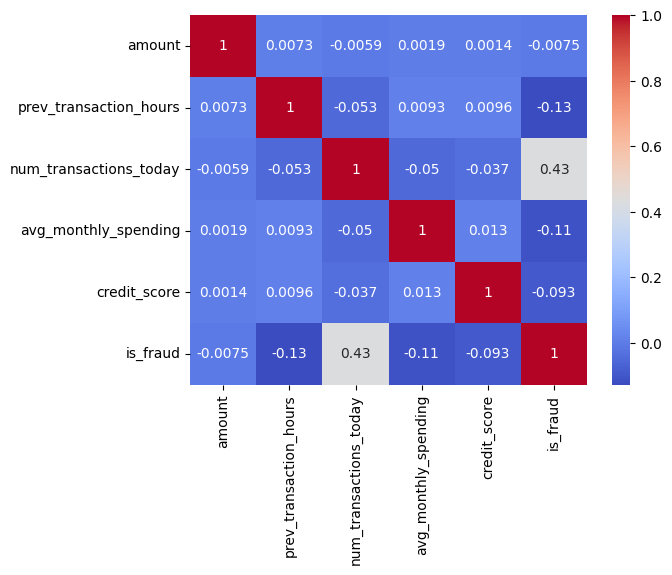

In [ ]:
sns.heatmap(df.corr(method='pearson',numeric_only=True), annot=True, cmap='coolwarm')
plt.show()

## Visualizing Distribution of Amounts and Fraud Instances
Understanding these distributions can reveal important patterns and help in identifying characteristics of fraudulent transactions.

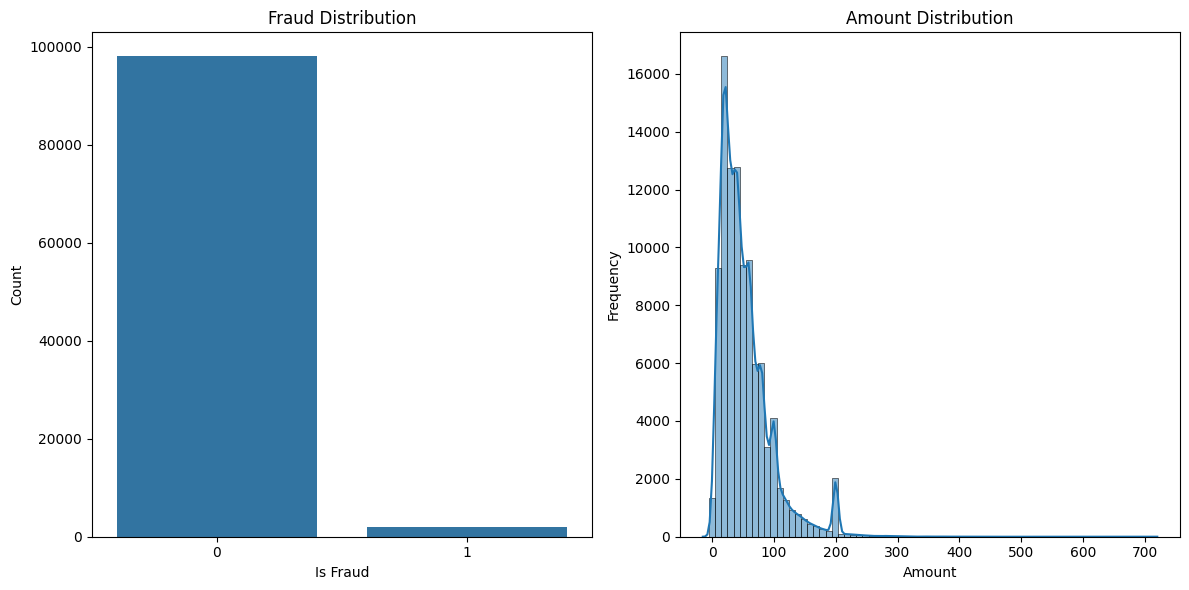

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
# Fraud Distribution
sns.countplot(x='is_fraud', data=df, ax=axes[0])
axes[0].set_title('Fraud Distribution')
axes[0].set_xlabel('Is Fraud')
axes[0].set_ylabel('Count')

# Amount Distribution
sns.histplot(df['amount'], binwidth=10, ax=axes[1], kde=True)
axes[1].set_title('Amount Distribution')
axes[1].set_xlabel('Amount')
axes[1].set_ylabel('Frequency')

plt.tight_layout()

plt.show()

#Amount and Fraud Distribution are left skewed - key challenge with modeling

<Figure size 1500x800 with 0 Axes>

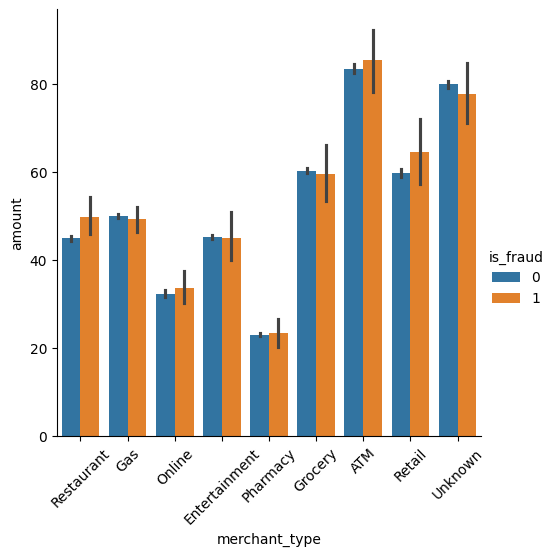

In [ ]:
plt.figure(figsize=(15,8))
sns.catplot(data=df, x= 'merchant_type', y='amount', kind='bar', hue='is_fraud')
plt.xticks(rotation=45)
plt.show()

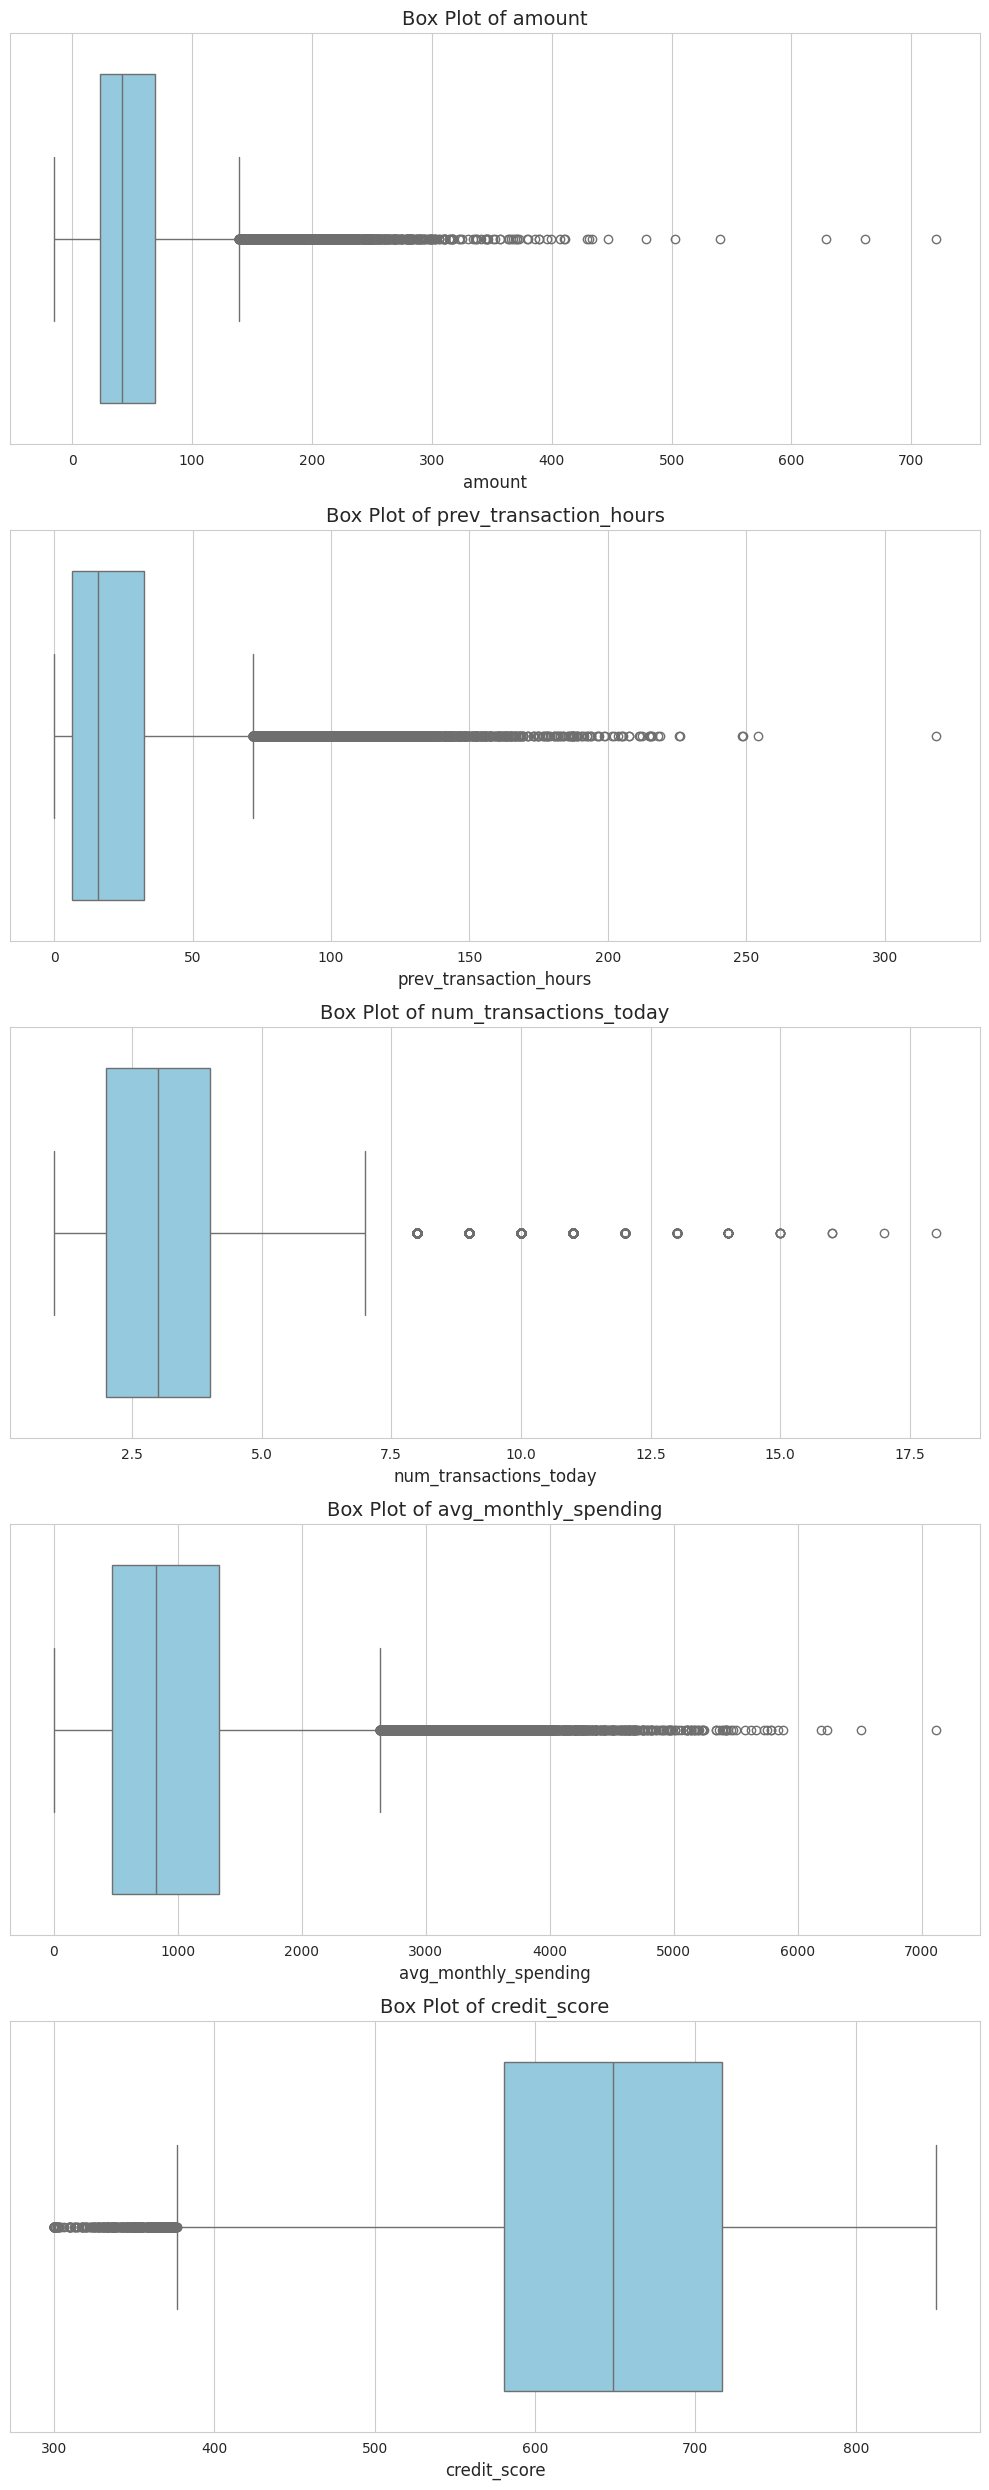

In [ ]:
numerical_cols = [
    'amount',
    'prev_transaction_hours',
    'num_transactions_today',
    'avg_monthly_spending',
    'credit_score'
]

sns.set_style("whitegrid")

# Create subplots for each numerical column
fig, axes = plt.subplots(nrows=len(numerical_cols), ncols=1,
                         figsize=(10, 5 * len(numerical_cols)))


if len(numerical_cols) == 1:
    axes = [axes]

for i, col in enumerate(numerical_cols):
    sns.boxplot(x=df[col], ax=axes[i], color='skyblue')
    axes[i].set_title(f'Box Plot of {col}', fontsize=14)
    axes[i].set_xlabel(col, fontsize=12)
    axes[i].tick_params(axis='x', labelsize=10)

plt.tight_layout()
plt.show()

# **Feature Engineering**

## Addressing Data Imbalance
Given our synthetic dataset has a 0.02% fraud rate, we are dealing with a highly imbalanced dataset. This imbalance can significantly affect the performance of machine learning models, as models might be biased towards the majority class (non-fraudulent transactions) and perform poorly in detecting the minority class (fraudulent transactions)


In [ ]:
# Enhancing features for preprocessing
df["timestamp"] = pd.to_datetime(df["timestamp"])

# Monday=0, Sunday=6
df['day_of_week'] = df['timestamp'].dt.dayofweek

# Weekends labeled as '1', weekdays as '0"
df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)
df['month'] = df['timestamp'].dt.month
df['day_of_month'] = df['timestamp'].dt.day
df['hour_of_day'] = df['timestamp'].dt.hour

In [ ]:
# Drop unnecessary columns
columns_to_drop = [ "account_created"
                      , "timestamp", "account_number"]
df.drop([col for col in columns_to_drop if col in df.columns],
                     axis=1, inplace=True)

In [ ]:
df.head()

,transaction_id,amount,merchant_type,location,prev_transaction_hours,num_transactions_today,avg_monthly_spending,credit_score,is_fraud,day_of_week,is_weekend,month,day_of_month,hour_of_day
0,TXN039926,40.81,Restaurant,"Chapel Hill, USA",39.296206,2,422.705537,598.766701,0,4,0,11,22,23
1,TXN062789,69.94,Gas,"Chapel Hill, USA",11.231314,3,695.165513,773.851406,0,0,0,4,14,7
2,TXN018232,10.49,Online,"Chapel Hill, USA",90.818533,4,1072.855745,633.157543,0,0,0,3,17,12
3,TXN011941,47.15,Entertainment,"Los Angeles, USA",30.395480,2,418.537760,659.781576,0,0,0,6,2,4
4,TXN020241,17.77,Entertainment,"Berlin, Germany",3.715145,2,86.098224,519.137816,0,0,0,1,20,5


## Splitting Data For Model Construction
Before training any machine learning models, it's essential to split our dataset into distinct subsets. This ensures that we can evaluate our model's performance on unseen data, providing a more reliable assessment of its generalization capabilities. This section will focus on:

Train-Test Split: Dividing the dataset into training and testing sets. The training set will be used to train the model, while the testing set will be reserved for evaluating its performance.

Validation Set (Optional but Recommended): For hyperparameter tuning and model selection, an additional validation set can be created from the training data (e.g., using cross-validation or a further split). This helps in optimizing model parameters without "peeking" at the final test set.



*   Train Set: 80%
*   Test Set: 10%
*   Validation Set: 10%






In [ ]:
X = df.drop(['transaction_id', 'is_fraud'], axis=1)
y = df['is_fraud']

categorical_columns = ['merchant_type', 'location']
label_encoders = {}

for col in categorical_columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le

#Splitting dataset into test / train / validation sets

#Train Set: 80%
#Test Set: 10%
#Validation Set: 10%

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.10, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.111, random_state=42, stratify=y_train_val)

# Verifying shape of train / test data
print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Training class distribution:\n{y_train.value_counts()}")

Training set shape: (80010, 12)
Test set shape: (10000, 12)
Training class distribution:
is_fraud
0    78410
1     1600
Name: count, dtype: int64


## Normalizing Data using RobustScaler
Given the potential for outliers in financial transaction data, RobustScaler is an ideal choice for normalizing our features. Unlike StandardScaler or MinMaxScaler, RobustScaler scales features using the median and interquartile range (IQR), making it robust to extreme values. This ensures that our model isn't unduly influenced by outliers, leading to more stable and reliable training

In [ ]:
scaler = RobustScaler()
X_train_processed = scaler.fit_transform(X_train)
X_val_processed = scaler.transform(X_val) # Transform validation set
X_test_processed = scaler.transform(X_test) # Transform test set

X_train_scaled = pd.DataFrame(X_train_processed, columns=X_train.columns, index=X_train.index)
X_val_scaled = pd.DataFrame(X_val_processed, columns=X_val.columns, index=X_val.index)
X_test_scaled = pd.DataFrame(X_test_processed, columns=X_test.columns, index=X_test.index)

# **Oversampling**

## Applying SMOTE for Imbalance Handling
As identified earlier, our dataset suffers from severe class imbalance, with fraudulent transactions representing a tiny fraction of the total records. This imbalance can lead to machine learning models that are biased towards the majority class and perform poorly in detecting the rare, but critical, fraudulent cases.


In [ ]:
smote = SMOTETomek(random_state=42)
X_train_data, y_train_data = smote.fit_resample(X_train_scaled, y_train)

## Training Ensemble Models: Random Forest and XGBoost
In this section, we will train two powerful ensemble machine learning models: Random Forest and XGBoost. Both are widely recognized for their high performance in classification tasks and their ability to handle complex datasets, making them excellent choices for fraud detection.

In [ ]:
def train_and_evaluate_ensemble_models(X_train_data, y_train_data, X_val_data, y_val_data, X_test_data, y_test_data):

  # be catious of increasing tree depth on models as it will create a more
  # complex model(costly) and increase the liklihood of overfitting(default=6)
  # simple function that allows us to train both models at once and store / print results

    models = {
        'Random Forest': RandomForestClassifier(n_estimators=300, max_features='log2', random_state=42,
                                                max_depth=30),
        'XGBoost': xgb.XGBClassifier(n_estimators=200, max_depth=5, learning_rate=0.1, subsample=1,
                                     colsample_bytree=.8, random_state=42, eval_metric='logloss',
                                     scale_pos_weight=1, use_label_encoder=False,
                                     early_stopping_rounds=50)
    }

    ensemble_results = {}

    for name, model in models.items():
        print(f"\nTraining {name}")
        start_time = time.time()

        if name == 'XGBoost':


            model.fit(X_train_data, y_train_data,
                      eval_set=[(X_val_data, y_val_data)],
                      verbose=False)
        else:
            # Random Forest: fit on the resampled training data
            model.fit(X_train_data, y_train_data)

        #starting train time
        train_time = time.time() - start_time


        y_pred = model.predict(X_test_data)
        y_pred_proba = model.predict_proba(X_test_data)[:, 1]


        auc_score = roc_auc_score(y_test_data, y_pred_proba)

        ensemble_results[name] = {
            'model': model,
            'y_pred': y_pred,
            'y_pred_proba': y_pred_proba,
            'auc_score': auc_score,
            'train_time': train_time
        }

        print(f"Training time: {train_time:.2f} seconds")
        print(f"AUC Score (on Test Set): {auc_score:.4f}")
        print("\nClassification Report (Test Set):")
        print(classification_report(y_test_data, y_pred))
        print("-" * 50)

    return ensemble_results


ensemble_results = train_and_evaluate_ensemble_models(X_train_data, y_train_data,
                                                      X_val_scaled, y_val, X_test_scaled, y_test)

# Model comparison
print("--- ENSEMBLE MODEL COMPARISON (Test Set) ---")
for name, result in ensemble_results.items():
    print(f"{name}: AUC = {result['auc_score']:.4f}, "
          f"Training Time = {result['train_time']:.2f}s")


Training Random Forest
Training time: 135.67 seconds
AUC Score (on Test Set): 0.9977

Classification Report (on Test Set):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9800
           1       0.83      0.86      0.85       200

    accuracy                           0.99     10000
   macro avg       0.91      0.93      0.92     10000
weighted avg       0.99      0.99      0.99     10000

--------------------------------------------------

Training XGBoost
Training time: 2.27 seconds
AUC Score (on Test Set): 0.9981

Classification Report (on Test Set):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9800
           1       0.85      0.90      0.87       200

    accuracy                           0.99     10000
   macro avg       0.92      0.95      0.93     10000
weighted avg       0.99      0.99      0.99     10000

--------------------------------------------------
--- 

## Visual Comparsion (Train Set)
This section focuses on visually comparing the performance of our trained Random Forest and XGBoost models on the training set. While the primary evaluation will be on unseen validation/test data, analyzing training set performance can provide initial insights into:

Model Learning: How well each model has learned the patterns within the data it was trained on.

Potential Overfitting: Early indications if a model is memorizing the training data too closely, which might not generalize well to new data.

Class Separation: How effectively each model distinguishes between legitimate and fraudulent transactions within the training data space.

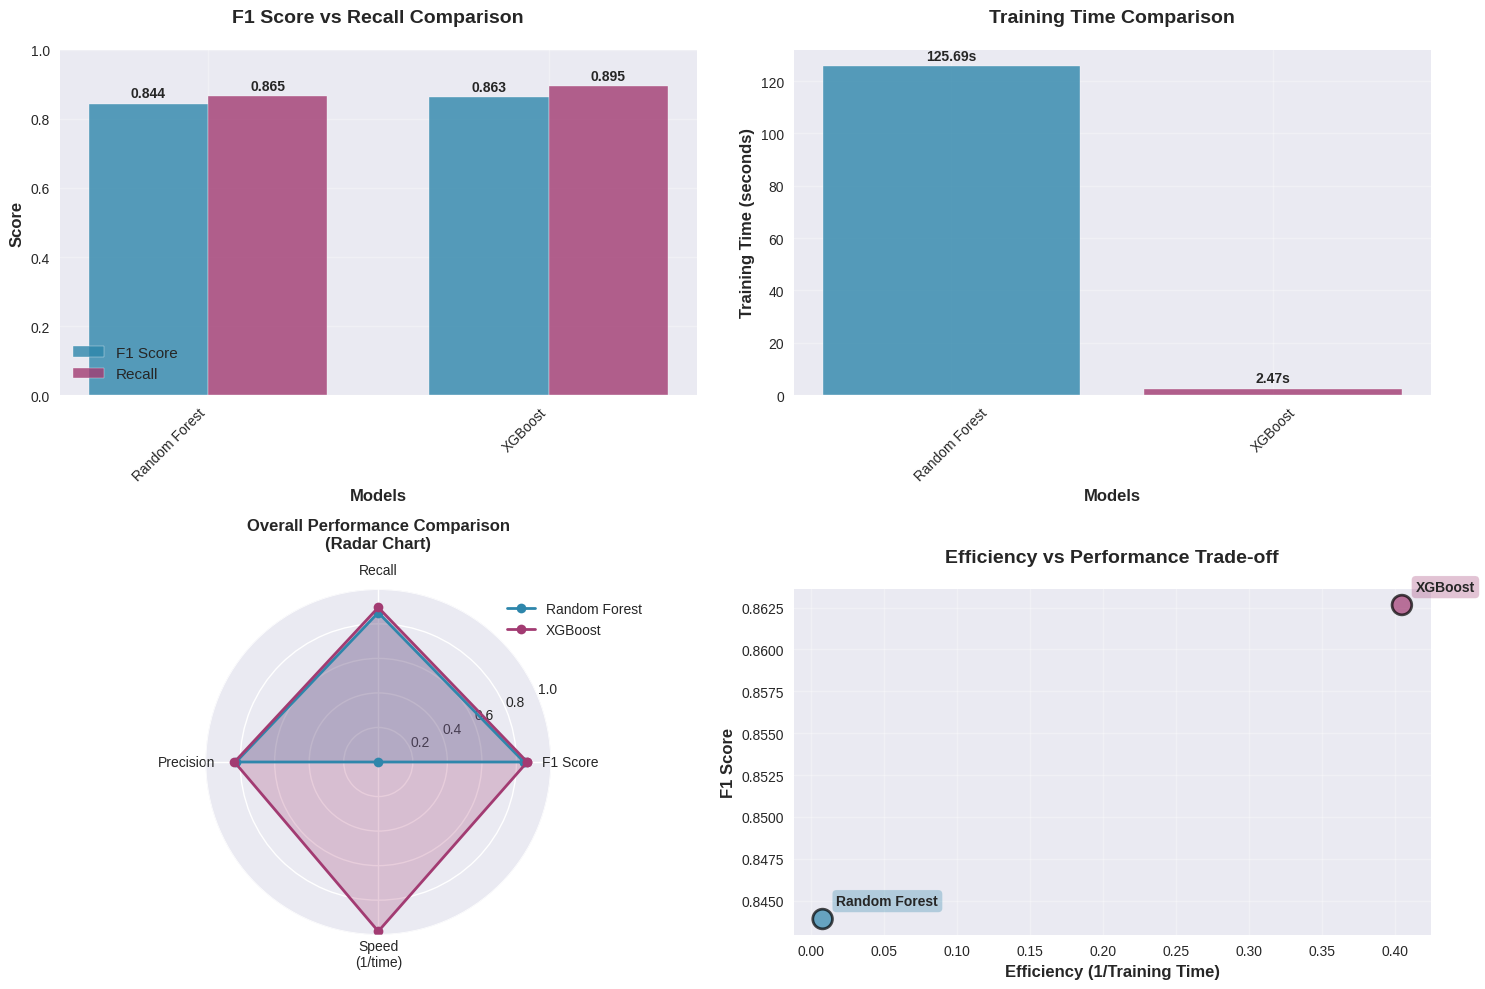


MODEL PERFORMANCE SUMMARY
Model           F1 Score   Recall     Precision    Train Time  
--------------------------------------------------------------------------------
Random Forest   0.8439     0.8650     0.8238       125.69      s
XGBoost         0.8627     0.8950     0.8326       2.47        s


In [ ]:
def plot_model_comparisons(results, y_test):

    # Calculate metrics for each model
    model_names = list(results.keys())
    f1_scores = []
    recall_scores = []
    precision_scores = []
    training_times = []

    for name, result in results.items():
        f1 = f1_score(y_test, result['y_pred'])
        recall = recall_score(y_test, result['y_pred'])
        precision = precision_score(y_test, result['y_pred'])

        f1_scores.append(f1)
        recall_scores.append(recall)
        precision_scores.append(precision)
        training_times.append(result['train_time'])

    # Set up the plotting style
    plt.style.use('seaborn-v0_8')
    fig = plt.figure(figsize=(15, 10))

    # Color palette
    colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D'][:len(model_names)]

    # Plot 1: F1 Score and Recall Comparison (Bar Chart)
    ax1 = plt.subplot(2, 2, 1)
    x = np.arange(len(model_names))
    width = 0.35

    bars1 = ax1.bar(x - width/2, f1_scores, width, label='F1 Score', color=colors[0], alpha=0.8)
    bars2 = ax1.bar(x + width/2, recall_scores, width, label='Recall', color=colors[1], alpha=0.8)

    ax1.set_xlabel('Models', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Score', fontsize=12, fontweight='bold')
    ax1.set_title('F1 Score vs Recall Comparison', fontsize=14, fontweight='bold', pad=20)
    ax1.set_xticks(x)
    ax1.set_xticklabels(model_names, rotation=45, ha='right')
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(0, 1.0)

    # Add value labels on bars
    for bar in bars1:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontweight='bold')

    for bar in bars2:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontweight='bold')

    # Plot 2: Training Time Comparison (Bar Chart)
    ax2 = plt.subplot(2, 2, 2)
    bars3 = ax2.bar(model_names, training_times, color=colors, alpha=0.8)

    ax2.set_xlabel('Models', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Training Time (seconds)', fontsize=12, fontweight='bold')
    ax2.set_title('Training Time Comparison', fontsize=14, fontweight='bold', pad=20)
    ax2.tick_params(axis='x', rotation=45)
    ax2.grid(True, alpha=0.3)

    # Add value labels on bars
    for bar in bars3:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + max(training_times)*0.01,
                f'{height:.2f}s', ha='center', va='bottom', fontweight='bold')

    # Plot 3: Comprehensive Performance Radar Chart
    ax3 = plt.subplot(2, 2, 3, projection='polar')

    # Metrics for radar chart
    metrics = ['F1 Score', 'Recall', 'Precision', 'Speed\n(1/time)']

    # Normalize training time for radar chart (inverse for speed)
    max_time = max(training_times)
    speed_scores = [(max_time - time) / max_time for time in training_times]

    angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
    angles += angles[:1]  # Complete the circle

    for i, name in enumerate(model_names):
        values = [f1_scores[i], recall_scores[i], precision_scores[i], speed_scores[i]]
        values += values[:1]  # Complete the circle

        ax3.plot(angles, values, 'o-', linewidth=2, label=name, color=colors[i])
        ax3.fill(angles, values, alpha=0.25, color=colors[i])

    ax3.set_xticks(angles[:-1])
    ax3.set_xticklabels(metrics, fontsize=10)
    ax3.set_ylim(0, 1)
    ax3.set_title('Overall Performance Comparison\n(Radar Chart)',
                  fontsize=12, fontweight='bold', pad=30)
    ax3.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
    ax3.grid(True)

    # Plot 4: Efficiency vs Performance Scatter Plot
    ax4 = plt.subplot(2, 2, 4)

    # Use F1 score as performance metric and inverse of time as efficiency
    efficiency = [1/time for time in training_times]

    scatter = ax4.scatter(efficiency, f1_scores, c=colors[:len(model_names)],
                         s=200, alpha=0.7, edgecolors='black', linewidth=2)

    # Add model labels
    for i, name in enumerate(model_names):
        ax4.annotate(name, (efficiency[i], f1_scores[i]),
                    xytext=(10, 10), textcoords='offset points',
                    fontsize=10, fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor=colors[i], alpha=0.3))

    ax4.set_xlabel('Efficiency (1/Training Time)', fontsize=12, fontweight='bold')
    ax4.set_ylabel('F1 Score', fontsize=12, fontweight='bold')
    ax4.set_title('Efficiency vs Performance Trade-off', fontsize=14, fontweight='bold', pad=20)
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print summary table
    print("\n" + "="*80)
    print("MODEL PERFORMANCE SUMMARY")
    print("="*80)
    print(f"{'Model':<15} {'F1 Score':<10} {'Recall':<10} {'Precision':<12} {'Train Time':<12}")
    print("-"*80)

    for i, name in enumerate(model_names):
        print(f"{name:<15} {f1_scores[i]:<10.4f} {recall_scores[i]:<10.4f} "
              f"{precision_scores[i]:<12.4f} {training_times[i]:<12.2f}s")

    return {
        'f1_scores': dict(zip(model_names, f1_scores)),
        'recall_scores': dict(zip(model_names, recall_scores)),
        'precision_scores': dict(zip(model_names, precision_scores)),
        'training_times': dict(zip(model_names, training_times))
    }

# Usage with your existing results:
plot_results = plot_model_comparisons(ensemble_results, y_test)



## Neural Network with K-Fold Cross Validation

In addition to ensemble methods, we will now build and evaluate a Neural Network (NN) model. Neural Networks are powerful models capable of learning complex non-linear relationships within data, making them highly effective for pattern recognition tasks like fraud detection.

To ensure a robust evaluation and mitigate the risk of overfitting, especially with a fixed train-test split, we will employ K-Fold Cross-Validation

**This code added by Ehsan: Quinton, please check to see if this makes sense.**

Here are the changes:
* SMOTETomek oversampling in each K-Fold split
* Per-fold metrics: Loss, Accuracy, AUC, Precision, Recall, F1 Score
* Final training on the full oversampled dataset
* Final evaluation on the test set
* Consistent naming (nn_model_smote, history_final_smote, etc.)







In [ ]:
# from sklearn.metrics import classification_report, roc_auc_score, precision_score, recall_score, f1_score
# from sklearn.preprocessing import RobustScaler
# from sklearn.model_selection import StratifiedKFold
# from imblearn.combine import SMOTETomek
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout
# from tensorflow.keras.losses import BinaryCrossentropy
# from tensorflow.keras.metrics import BinaryAccuracy
# from tensorflow.keras.callbacks import EarlyStopping
# from tensorflow.keras.optimizers import Adam
# import tensorflow as tf
# import numpy as np

# === Check GPU availability ===
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
print("Using GPU:", tf.test.gpu_device_name())

# === Function to build NN model for oversampling ===
def build_nn_model_smote(input_shape):
    model = Sequential([
        Dense(12, activation='relu', input_shape=(input_shape,)),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss=BinaryCrossentropy(),
                  metrics=[BinaryAccuracy()])
    return model

# === K-Fold Cross Validation ===
n_splits = 5
skf_smote = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Metrics containers
fold_roc_auc_smote = []
fold_accuracy_smote = []
fold_loss_smote = []
fold_precision_smote = []
fold_recall_smote = []
fold_f1_smote = []

for fold, (train_idx, val_idx) in enumerate(skf_smote.split(X_train_val, y_train_val)):
    print(f"\n--- Fold {fold+1}/{n_splits} (SMOTETomek Oversampling) ---")

    # Split fold data
    X_train_fold = X_train_val.iloc[train_idx]
    y_train_fold = y_train_val.iloc[train_idx]
    X_val_fold = X_train_val.iloc[val_idx]
    y_val_fold = y_train_val.iloc[val_idx]

    # Scale
    scaler_fold = RobustScaler()
    X_train_fold_scaled = scaler_fold.fit_transform(X_train_fold)
    X_val_fold_scaled = scaler_fold.transform(X_val_fold)

    # Apply SMOTETomek
    smote = SMOTETomek(random_state=42)
    X_train_fold_smote, y_train_fold_smote = smote.fit_resample(X_train_fold_scaled, y_train_fold)

    # Build and train model
    with tf.device('/GPU:0'):
        nn_model_smote = build_nn_model_smote(X_train_fold_smote.shape[1])
        early_stopping_smote = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)

        nn_model_smote.fit(
            X_train_fold_smote, y_train_fold_smote,
            validation_data=(X_val_fold_scaled, y_val_fold),
            epochs=100,
            batch_size=128,
            callbacks=[early_stopping_smote],
            verbose=0
        )

    # Evaluate
    loss = nn_model_smote.evaluate(X_val_fold_scaled, y_val_fold, verbose=0)[0]
    accuracy = nn_model_smote.evaluate(X_val_fold_scaled, y_val_fold, verbose=0)[1]
    y_pred_proba = nn_model_smote.predict(X_val_fold_scaled, verbose=0).flatten()
    y_pred = (y_pred_proba > 0.5).astype(int)
    auc = roc_auc_score(y_val_fold, y_pred_proba)
    precision = precision_score(y_val_fold, y_pred)
    recall = recall_score(y_val_fold, y_pred)
    f1 = f1_score(y_val_fold, y_pred)

    # Store metrics
    fold_loss_smote.append(loss)
    fold_accuracy_smote.append(accuracy)
    fold_roc_auc_smote.append(auc)
    fold_precision_smote.append(precision)
    fold_recall_smote.append(recall)
    fold_f1_smote.append(f1)

    print(f"Loss: {loss:.4f}, Accuracy: {accuracy:.4f}, AUC: {auc:.4f}")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

# === Summary ===
def summarize_metric(name, values):
    print(f"{name} Scores: {[f'{v:.4f}' for v in values]}")
    print(f"Mean {name}: {np.mean(values):.4f}")
    print(f"Std {name}: {np.std(values):.4f}\n")

print("\n--- Cross-Validation Summary (SMOTE) ---")
summarize_metric("Loss", fold_loss_smote)
summarize_metric("Accuracy", fold_accuracy_smote)
summarize_metric("AUC", fold_roc_auc_smote)
summarize_metric("Precision", fold_precision_smote)
summarize_metric("Recall", fold_recall_smote)
summarize_metric("F1 Score", fold_f1_smote)

# === Final Training on Full Training+Validation Set (SMOTE) ===
print("\n--- Final Training on Full Training+Validation Set (SMOTETomek) ---")

# Scale full dataset
scaler_final_smote = RobustScaler()
X_train_val_scaled = scaler_final_smote.fit_transform(X_train_val)
X_test_scaled = scaler_final_smote.transform(X_test)

# Apply SMOTETomek to full training set
smote_final = SMOTETomek(random_state=42)
X_train_val_smote, y_train_val_smote = smote_final.fit_resample(X_train_val_scaled, y_train_val)

# Train final model
with tf.device('/GPU:0'):
    nn_model_smote = build_nn_model_smote(X_train_val_smote.shape[1])
    early_stopping_final_smote = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)

    history_final_smote = nn_model_smote.fit(
        X_train_val_smote, y_train_val_smote,
        validation_split=0.1,
        epochs=100,
        batch_size=128,
        callbacks=[early_stopping_final_smote],
        verbose=0
    )

# Final evaluation on test set
test_loss_smote = nn_model_smote.evaluate(X_test_scaled, y_test, verbose=0)[0]
test_accuracy_smote = nn_model_smote.evaluate(X_test_scaled, y_test, verbose=0)[1]
y_test_pred_proba_smote = nn_model_smote.predict(X_test_scaled, verbose=0).flatten()
y_test_pred_smote = (y_test_pred_proba_smote > 0.5).astype(int)
test_auc_smote = roc_auc_score(y_test, y_test_pred_proba_smote)

print("\n--- Final SMOTE Model Evaluation on Test Set ---")
print(f"Test Loss: {test_loss_smote:.4f}")
print(f"Test Accuracy: {test_accuracy_smote:.4f}")
print(f"Test AUC Score: {test_auc_smote:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred_smote))


Num GPUs Available: 1
Using GPU: /device:GPU:0

--- Fold 1/5 (SMOTETomek Oversampling) ---
Loss: 0.0332, Accuracy: 0.9873, AUC: 0.9947
Precision: 0.6243, Recall: 0.9139, F1: 0.7418

--- Fold 2/5 (SMOTETomek Oversampling) ---
Loss: 0.0324, Accuracy: 0.9864, AUC: 0.9956
Precision: 0.6063, Recall: 0.9111, F1: 0.7281

--- Fold 3/5 (SMOTETomek Oversampling) ---
Loss: 0.0323, Accuracy: 0.9869, AUC: 0.9960
Precision: 0.6123, Recall: 0.9389, F1: 0.7412

--- Fold 4/5 (SMOTETomek Oversampling) ---
Loss: 0.0376, Accuracy: 0.9851, AUC: 0.9954
Precision: 0.5793, Recall: 0.9333, F1: 0.7149

--- Fold 5/5 (SMOTETomek Oversampling) ---
Loss: 0.0372, Accuracy: 0.9861, AUC: 0.9959
Precision: 0.5968, Recall: 0.9333, F1: 0.7281

--- Cross-Validation Summary (SMOTE) ---
Loss Scores: ['0.0332', '0.0324', '0.0323', '0.0376', '0.0372']
Mean Loss: 0.0346
Std Loss: 0.0024

Accuracy Scores: ['0.9873', '0.9864', '0.9869', '0.9851', '0.9861']
Mean Accuracy: 0.9863
Std Accuracy: 0.0007

AUC Scores: ['0.9947', '0.995

## Training History
This section will analyze the training history of our models, particularly relevant for the Neural Network. Examining the training progress provides valuable insights into how the models learned over time, helping us to:

* Identify Overfitting/Underfitting: Observe if the model is memorizing the
training data too well (overfitting) or if it's not learning enough (underfitting).

* Monitor Convergence: See if the model's performance metrics (e.g., loss, accuracy) are stabilizing, indicating convergence.

* Optimize Hyperparameters: Inform decisions on adjusting learning rates, number of epochs, or regularization techniques for future training.

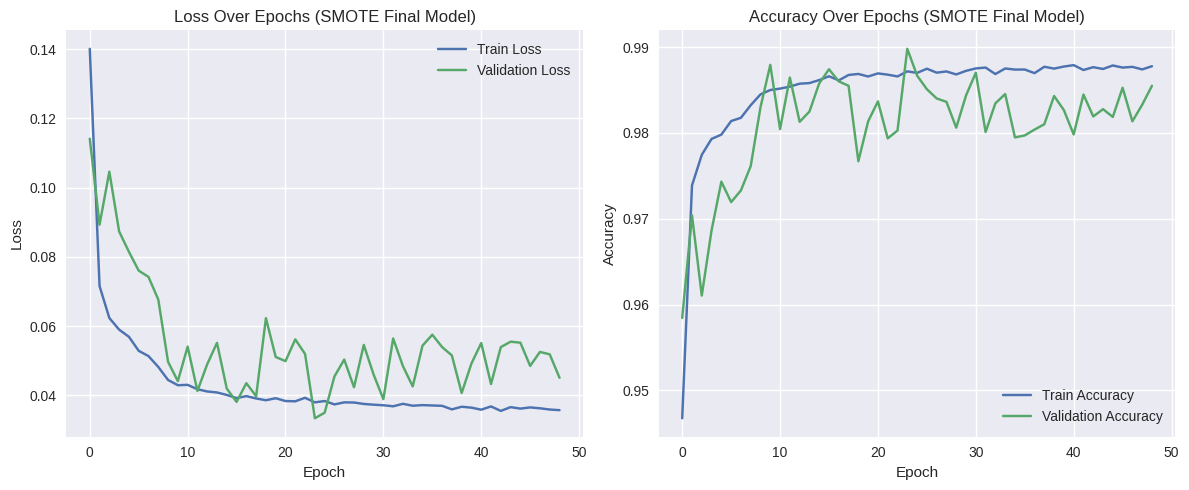

In [ ]:
# import matplotlib.pyplot as plt

# Plot training & validation loss and accuracy
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history_final_smote.history['loss'], label='Train Loss')
plt.plot(history_final_smote.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs (SMOTE Final Model)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_final_smote.history['binary_accuracy'], label='Train Accuracy')
plt.plot(history_final_smote.history['val_binary_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs (SMOTE Final Model)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# **Undersampling**

## Applying Undersampling

In [ ]:
# Importing
from imblearn.under_sampling import RandomUnderSampler

# Apply random undersampling
undersampler = RandomUnderSampler(random_state=42)
X_train_under, y_train_under = undersampler.fit_resample(X_train_scaled, y_train)

# Verify shape and class distribution
print(f"Undersampled training set shape: {X_train_under.shape}")
print(f"Undersampled class distribution:\n{y_train_under.value_counts()}")


Undersampled training set shape: (3200, 12)
Undersampled class distribution:
is_fraud
0    1600
1    1600
Name: count, dtype: int64


## Training Ensemble Models: Random Forest and XGBoost

In [ ]:
ensemble_results_under = train_and_evaluate_ensemble_models(
    X_train_under, y_train_under,
    X_val_scaled, y_val,
    X_test_scaled, y_test
)


Training Random Forest
Training time: 1.39 seconds
AUC Score (on Test Set): 0.9977

Classification Report (on Test Set):
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      9800
           1       0.50      0.99      0.66       200

    accuracy                           0.98     10000
   macro avg       0.75      0.98      0.83     10000
weighted avg       0.99      0.98      0.98     10000

--------------------------------------------------

Training XGBoost
Training time: 0.25 seconds
AUC Score (on Test Set): 0.9981

Classification Report (on Test Set):
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      9800
           1       0.47      0.97      0.63       200

    accuracy                           0.98     10000
   macro avg       0.73      0.98      0.81     10000
weighted avg       0.99      0.98      0.98     10000

--------------------------------------------------


## Visual Comparison

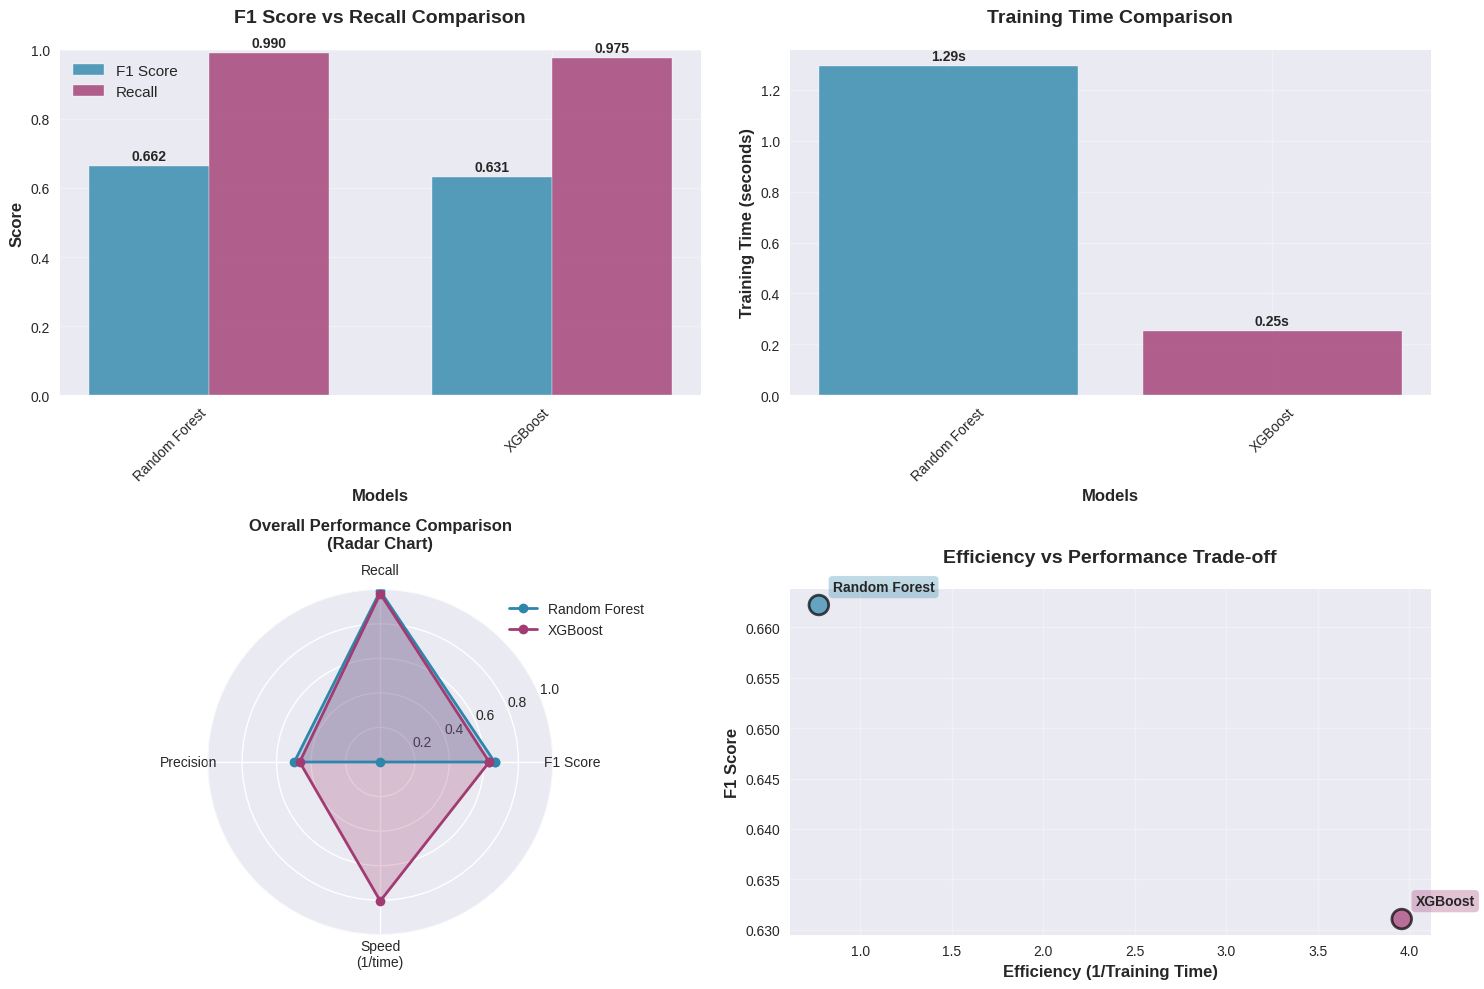


MODEL PERFORMANCE SUMMARY
Model           F1 Score   Recall     Precision    Train Time  
--------------------------------------------------------------------------------
Random Forest   0.6622     0.9900     0.4975       1.29        s
XGBoost         0.6311     0.9750     0.4665       0.25        s


In [ ]:
plot_results_under = plot_model_comparisons(ensemble_results_under, y_test)


## Neural Network with K-Fold Cross Validation

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import StratifiedKFold
from imblearn.under_sampling import RandomUnderSampler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import numpy as np

# === Check GPU availability ===
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
print("Using GPU:", tf.test.gpu_device_name())

# === Function to build NN model ===
def build_nn_model_under(input_shape):
    model = Sequential([
        Dense(12, activation='relu', input_shape=(input_shape,)),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss=BinaryCrossentropy(),
                  metrics=[BinaryAccuracy()])
    return model

# === K-Fold Cross Validation ===
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Metric containers
fold_roc_auc = []
fold_accuracy = []
fold_loss = []
fold_precision = []
fold_recall = []
fold_f1 = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_val, y_train_val)):
    print(f"\n--- Fold {fold+1}/{n_splits} ---")

    # Split fold data
    X_train_fold = X_train_val.iloc[train_idx]
    y_train_fold = y_train_val.iloc[train_idx]
    X_val_fold = X_train_val.iloc[val_idx]
    y_val_fold = y_train_val.iloc[val_idx]

    # Scale
    scaler_fold = RobustScaler()
    X_train_fold_scaled = scaler_fold.fit_transform(X_train_fold)
    X_val_fold_scaled = scaler_fold.transform(X_val_fold)

    # Apply undersampling
    undersampler = RandomUnderSampler(random_state=42)
    X_train_fold_under, y_train_fold_under = undersampler.fit_resample(X_train_fold_scaled, y_train_fold)

    # Train model
    with tf.device('/GPU:0'):
        nn_model_under = build_nn_model_under(X_train_fold_under.shape[1])
        early_stopping = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)

        nn_model_under.fit(
            X_train_fold_under, y_train_fold_under,
            validation_data=(X_val_fold_scaled, y_val_fold),
            epochs=100,
            batch_size=128,
            callbacks=[early_stopping],
            verbose=0
        )

    # Evaluate
    loss = nn_model_under.evaluate(X_val_fold_scaled, y_val_fold, verbose=0)[0]
    accuracy = nn_model_under.evaluate(X_val_fold_scaled, y_val_fold, verbose=0)[1]
    y_pred_proba = nn_model_under.predict(X_val_fold_scaled, verbose=0).flatten()
    y_pred = (y_pred_proba > 0.5).astype(int)
    auc = roc_auc_score(y_val_fold, y_pred_proba)
    precision = precision_score(y_val_fold, y_pred)
    recall = recall_score(y_val_fold, y_pred)
    f1 = f1_score(y_val_fold, y_pred)

    # Store metrics
    fold_loss.append(loss)
    fold_accuracy.append(accuracy)
    fold_roc_auc.append(auc)
    fold_precision.append(precision)
    fold_recall.append(recall)
    fold_f1.append(f1)

    print(f"Loss: {loss:.4f}, Accuracy: {accuracy:.4f}, AUC: {auc:.4f}")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

# === Summary ===
def summarize_metric(name, values):
    print(f"{name} Scores: {[f'{v:.4f}' for v in values]}")
    print(f"Mean {name}: {np.mean(values):.4f}")
    print(f"Std {name}: {np.std(values):.4f}\n")

print("\n--- Cross-Validation Summary ---")
summarize_metric("Loss", fold_loss)
summarize_metric("Accuracy", fold_accuracy)
summarize_metric("AUC", fold_roc_auc)
summarize_metric("Precision", fold_precision)
summarize_metric("Recall", fold_recall)
summarize_metric("F1 Score", fold_f1)

# === Final Training on Full Training Set (Undersampled) ===
print("\n--- Final Training on Full Training+Validation Set (Undersampled) ---")

# Scale full training data
scaler_final = RobustScaler()
X_train_val_scaled = scaler_final.fit_transform(X_train_val)
X_test_scaled = scaler_final.transform(X_test)

# Undersample full training data
undersampler_final = RandomUnderSampler(random_state=42)
X_train_val_under, y_train_val_under = undersampler_final.fit_resample(X_train_val_scaled, y_train_val)

# Train final model
with tf.device('/GPU:0'):
    nn_model_under = build_nn_model_under(X_train_val_under.shape[1])
    early_stopping_final = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)

    history_final_under = nn_model_under.fit(
    X_train_val_under, y_train_val_under,
    validation_split=0.1,
    epochs=100,
    batch_size=128,
    callbacks=[early_stopping_final],
    verbose=0
)

# Final evaluation on test set
test_loss = nn_model_under.evaluate(X_test_scaled, y_test, verbose=0)[0]
test_accuracy = nn_model_under.evaluate(X_test_scaled, y_test, verbose=0)[1]
y_test_pred_proba = nn_model_under.predict(X_test_scaled, verbose=0).flatten()
y_test_pred = (y_test_pred_proba > 0.5).astype(int)
test_auc = roc_auc_score(y_test, y_test_pred_proba)

print("\n--- Final Model Evaluation on Test Set ---")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test AUC Score: {test_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))


Num GPUs Available: 1
Using GPU: /device:GPU:0

--- Fold 1/5 ---
Loss: 0.0516, Accuracy: 0.9793, AUC: 0.9961
Precision: 0.4915, Recall: 0.9639, F1: 0.6510

--- Fold 2/5 ---
Loss: 0.0418, Accuracy: 0.9852, AUC: 0.9969
Precision: 0.5795, Recall: 0.9417, F1: 0.7175

--- Fold 3/5 ---
Loss: 0.0481, Accuracy: 0.9807, AUC: 0.9955
Precision: 0.5097, Recall: 0.9528, F1: 0.6641

--- Fold 4/5 ---
Loss: 0.0530, Accuracy: 0.9808, AUC: 0.9955
Precision: 0.5113, Recall: 0.9389, F1: 0.6621

--- Fold 5/5 ---
Loss: 0.0540, Accuracy: 0.9794, AUC: 0.9961
Precision: 0.4921, Recall: 0.9556, F1: 0.6497

--- Cross-Validation Summary ---
Loss Scores: ['0.0516', '0.0418', '0.0481', '0.0530', '0.0540']
Mean Loss: 0.0497
Std Loss: 0.0044

Accuracy Scores: ['0.9793', '0.9852', '0.9807', '0.9808', '0.9794']
Mean Accuracy: 0.9811
Std Accuracy: 0.0021

AUC Scores: ['0.9961', '0.9969', '0.9955', '0.9955', '0.9961']
Mean AUC: 0.9960
Std AUC: 0.0005

Precision Scores: ['0.4915', '0.5795', '0.5097', '0.5113', '0.4921']
M

## **Training History**

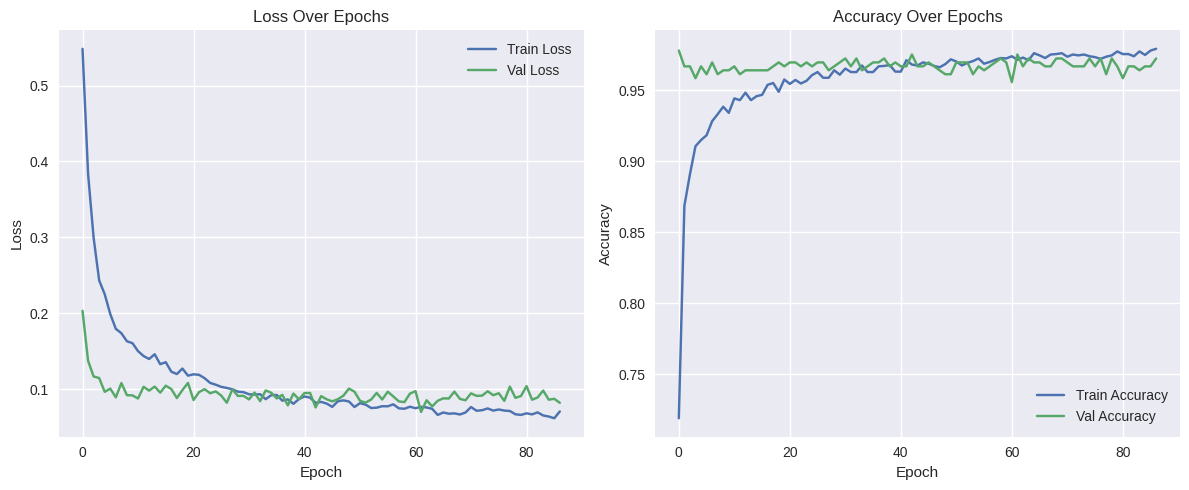

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation loss and accuracy
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history_final_under.history['loss'], label='Train Loss')
plt.plot(history_final_under.history['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_final_under.history['binary_accuracy'], label='Train Accuracy')
plt.plot(history_final_under.history['val_binary_accuracy'], label='Val Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# **Comparison**

## Comparison of Feature Importance for SMOTE and Undersampling using Random Forest and XGBoost


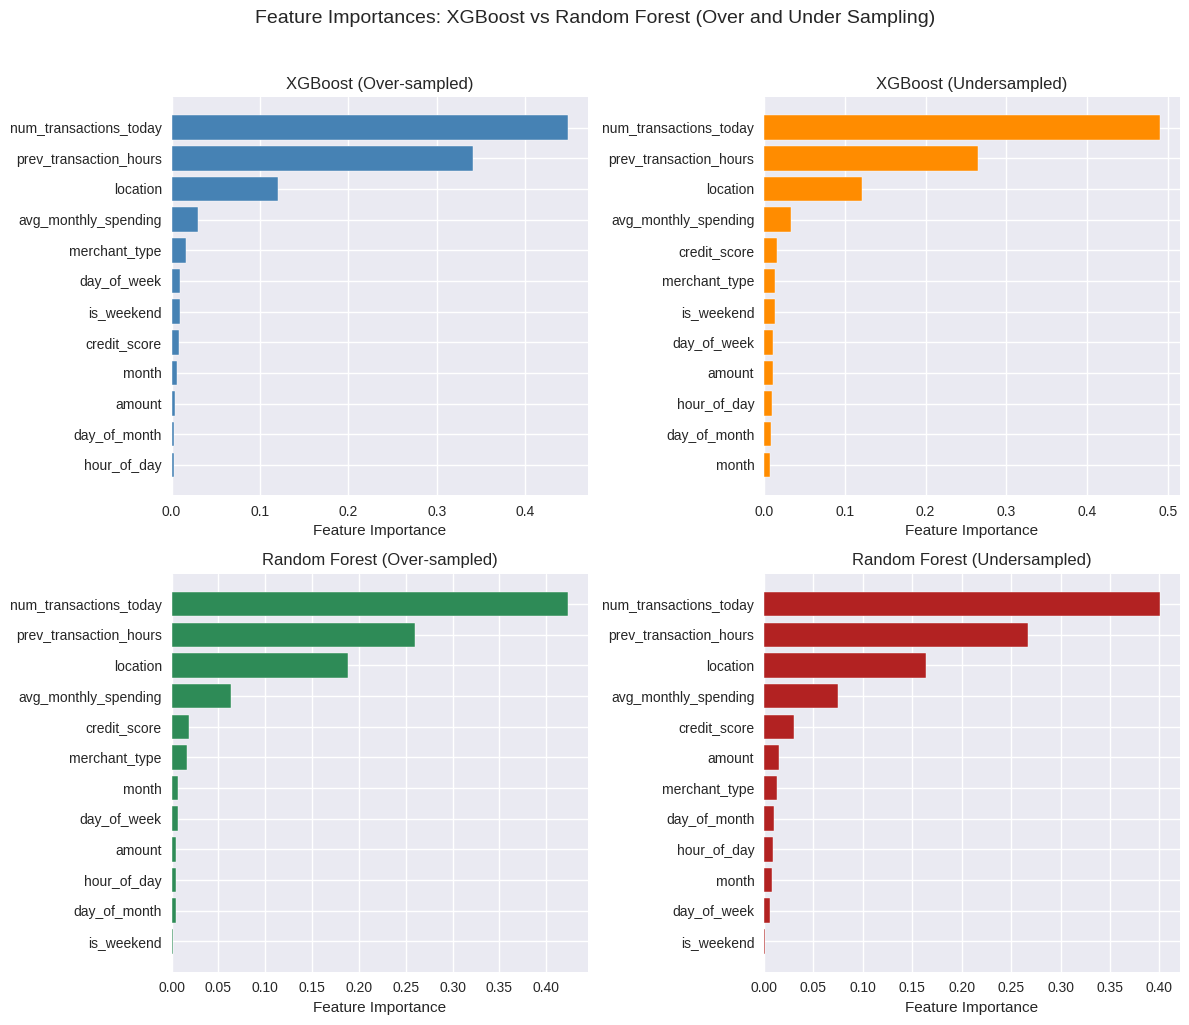

In [ ]:
import matplotlib.pyplot as plt

# Get feature names
feature_names = X_train_scaled.columns  # or X_train_under.columns if identical

# Create 2x2 grid for comparison
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Feature Importances: XGBoost vs Random Forest (Over and Under Sampling)', fontsize=14, y=1.02)

# --- XGBoost (Over) ---
feature_importances_xgb = ensemble_results['XGBoost']['model'].feature_importances_
sorted_idx_xgb = feature_importances_xgb.argsort()[::-1]
axes[0][0].barh(range(len(sorted_idx_xgb)), feature_importances_xgb[sorted_idx_xgb], color='steelblue')
axes[0][0].set_yticks(range(len(sorted_idx_xgb)))
axes[0][0].set_yticklabels([feature_names[i] for i in sorted_idx_xgb])
axes[0][0].invert_yaxis()
axes[0][0].set_title('XGBoost (Over-sampled)')
axes[0][0].set_xlabel('Feature Importance')

# --- XGBoost (Under) ---
feature_importances_xgb_under = ensemble_results_under['XGBoost']['model'].feature_importances_
sorted_idx_xgb_under = feature_importances_xgb_under.argsort()[::-1]
axes[0][1].barh(range(len(sorted_idx_xgb_under)), feature_importances_xgb_under[sorted_idx_xgb_under], color='darkorange')
axes[0][1].set_yticks(range(len(sorted_idx_xgb_under)))
axes[0][1].set_yticklabels([feature_names[i] for i in sorted_idx_xgb_under])
axes[0][1].invert_yaxis()
axes[0][1].set_title('XGBoost (Undersampled)')
axes[0][1].set_xlabel('Feature Importance')

# --- Random Forest (Over) ---
feature_importances_rf = ensemble_results['Random Forest']['model'].feature_importances_
sorted_idx_rf = feature_importances_rf.argsort()[::-1]
axes[1][0].barh(range(len(sorted_idx_rf)), feature_importances_rf[sorted_idx_rf], color='seagreen')
axes[1][0].set_yticks(range(len(sorted_idx_rf)))
axes[1][0].set_yticklabels([feature_names[i] for i in sorted_idx_rf])
axes[1][0].invert_yaxis()
axes[1][0].set_title('Random Forest (Over-sampled)')
axes[1][0].set_xlabel('Feature Importance')

# --- Random Forest (Under) ---
feature_importances_rf_under = ensemble_results_under['Random Forest']['model'].feature_importances_
sorted_idx_rf_under = feature_importances_rf_under.argsort()[::-1]
axes[1][1].barh(range(len(sorted_idx_rf_under)), feature_importances_rf_under[sorted_idx_rf_under], color='firebrick')
axes[1][1].set_yticks(range(len(sorted_idx_rf_under)))
axes[1][1].set_yticklabels([feature_names[i] for i in sorted_idx_rf_under])
axes[1][1].invert_yaxis()
axes[1][1].set_title('Random Forest (Undersampled)')
axes[1][1].set_xlabel('Feature Importance')

plt.tight_layout()
plt.show()


## Threshold Tuning for RF and XGBoost using SMOTE and Undersampling






================ RF MODEL METRICS ================

--- RF Over ---
>> Default Threshold (0.50)
              precision    recall  f1-score   support

           0     0.9972    0.9962    0.9967      9800
           1     0.8238    0.8650    0.8439       200

    accuracy                         0.9936     10000
   macro avg     0.9105    0.9306    0.9203     10000
weighted avg     0.9938    0.9936    0.9937     10000

>> Tuned Threshold (0.46)
              precision    recall  f1-score   support

           0     0.9976    0.9960    0.9968      9800
           1     0.8194    0.8850    0.8510       200

    accuracy                         0.9938     10000
   macro avg     0.9085    0.9405    0.9239     10000
weighted avg     0.9941    0.9938    0.9939     10000

--- RF Under ---
>> Default Threshold (0.50)
              precision    recall  f1-score   support

           0     0.9998    0.9795    0.9895      9800
           1     0.4962    0.9900    0.6611       200

    accuracy  

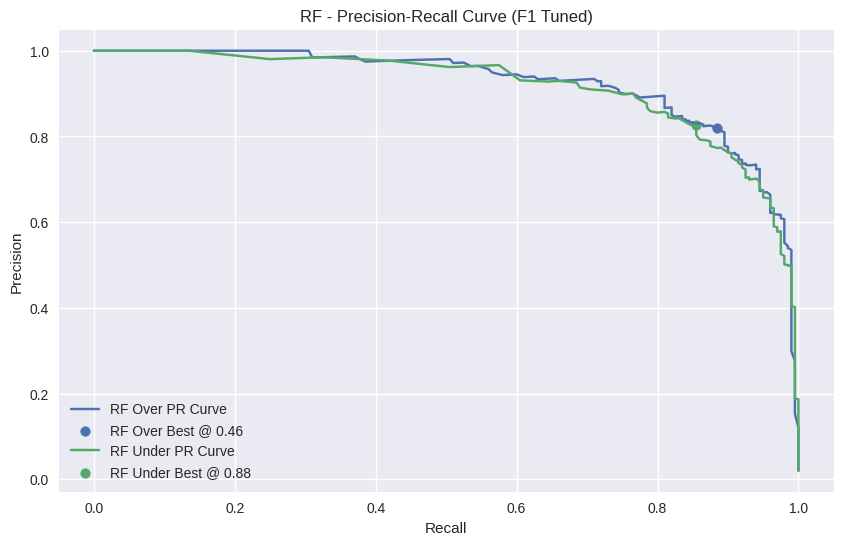

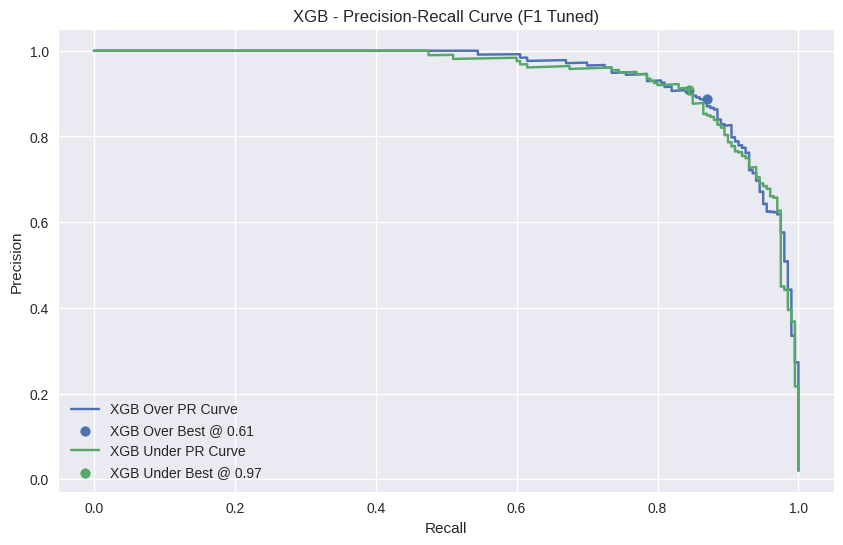

In [ ]:
from sklearn.metrics import precision_recall_curve, classification_report
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# STEP 1: Use previously trained models
proba_dict = {
    'RF Over': ensemble_results['Random Forest']['y_pred_proba'],
    'RF Under': ensemble_results_under['Random Forest']['y_pred_proba'],
    'XGB Over': ensemble_results['XGBoost']['y_pred_proba'],
    'XGB Under': ensemble_results_under['XGBoost']['y_pred_proba']
}

# STEP 2: F1-tuning function
def tune_threshold(y_true, y_proba):
    precision, recall, thresholds = precision_recall_curve(y_true, y_proba)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
    best_idx = np.argmax(f1_scores)
    return {
        'threshold': thresholds[best_idx],
        'curve': (recall, precision, best_idx)
    }

# STEP 3: Print per-class metrics for both thresholds
for model_group in ['RF', 'XGB']:
    print(f"\n================ {model_group} MODEL METRICS ================\n")
    for sampling in ['Over', 'Under']:
        label = f"{model_group} {sampling}"
        y_proba = proba_dict[label]
        tuned = tune_threshold(y_test, y_proba)
        best_threshold = tuned['threshold']

        y_pred_default = (y_proba >= 0.5).astype(int)
        y_pred_tuned = (y_proba >= best_threshold).astype(int)

        print(f"--- {label} ---")
        print(">> Default Threshold (0.50)")
        print(classification_report(y_test, y_pred_default, digits=4))
        print(f">> Tuned Threshold ({best_threshold:.2f})")
        print(classification_report(y_test, y_pred_tuned, digits=4))

# STEP 4: Plot PR curves
for model_group in ['RF', 'XGB']:
    plt.figure(figsize=(10, 6))
    for sampling in ['Over', 'Under']:
        label = f"{model_group} {sampling}"
        tuned = tune_threshold(y_test, proba_dict[label])
        recall, precision, best_idx = tuned['curve']
        plt.plot(recall, precision, label=f"{label} PR Curve")
        plt.scatter(recall[best_idx], precision[best_idx],
                    label=f"{label} Best @ {tuned['threshold']:.2f}")
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f"{model_group} - Precision-Recall Curve (F1 Tuned)")
    plt.grid(True)
    plt.legend()
    plt.show()



## Threshold Tuning for Neural Network using SMOTE and Undersampling


=== Neural Network - SMOTE or Full ===
>> Default Threshold (0.50):
              precision    recall  f1-score   support

           0     0.9995    0.9896    0.9945      9800
           1     0.6566    0.9750    0.7847       200

    accuracy                         0.9893     10000
   macro avg     0.8280    0.9823    0.8896     10000
weighted avg     0.9926    0.9893    0.9903     10000

>> Tuned Threshold (0.87):
              precision    recall  f1-score   support

           0     0.9985    0.9959    0.9972      9800
           1     0.8222    0.9250    0.8706       200

    accuracy                         0.9945     10000
   macro avg     0.9103    0.9605    0.9339     10000
weighted avg     0.9949    0.9945    0.9947     10000

AUC: 0.9986

=== Neural Network - Undersampled ===
>> Default Threshold (0.50):
              precision    recall  f1-score   support

           0     0.9994    0.9772    0.9882      9800
           1     0.4652    0.9700    0.6288       200

    ac

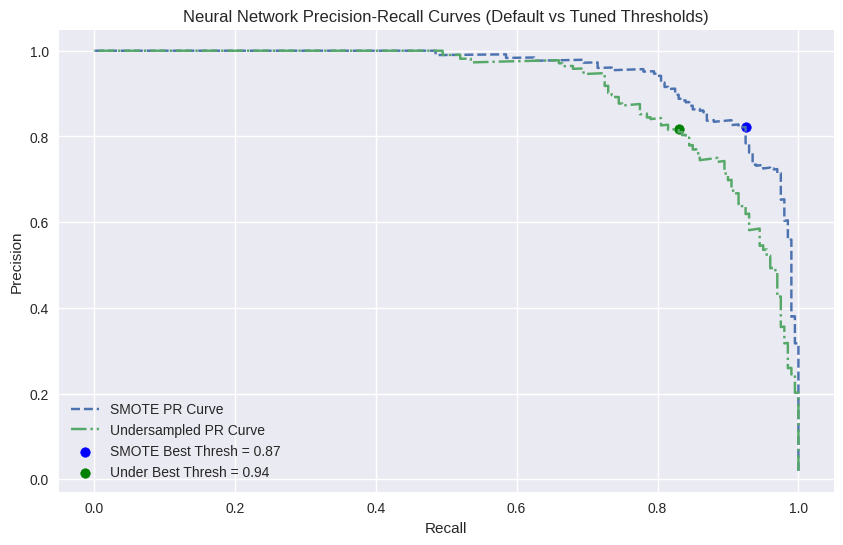

In [ ]:
from sklearn.metrics import precision_recall_curve, classification_report, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

# === Predict probabilities from both trained models ===
# Replace with actual model objects if named differently
y_test_pred_proba_under = nn_model_under.predict(X_test_scaled, verbose=0).flatten()
y_test_pred_proba_smote = nn_model_smote.predict(X_test_scaled, verbose=0).flatten()

# === Define evaluation and plotting function ===
def evaluate_thresholds(y_true, y_proba, label):
    precision, recall, thresholds = precision_recall_curve(y_true, y_proba)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
    best_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_idx]

    y_pred_default = (y_proba >= 0.5).astype(int)
    y_pred_tuned = (y_proba >= best_threshold).astype(int)

    print(f"\n=== {label} ===")
    print(">> Default Threshold (0.50):")
    print(classification_report(y_true, y_pred_default, digits=4))
    print(f">> Tuned Threshold ({best_threshold:.2f}):")
    print(classification_report(y_true, y_pred_tuned, digits=4))
    print(f"AUC: {roc_auc_score(y_true, y_proba):.4f}")

    return recall, precision, best_idx, best_threshold

# === Evaluate both models ===
recall_smote, precision_smote, best_idx_smote, best_thresh_smote = evaluate_thresholds(
    y_test, y_test_pred_proba_smote, "Neural Network - SMOTE or Full")

recall_under, precision_under, best_idx_under, best_thresh_under = evaluate_thresholds(
    y_test, y_test_pred_proba_under, "Neural Network - Undersampled")

# === Plot Precision-Recall curves ===
plt.figure(figsize=(10, 6))
plt.plot(recall_smote, precision_smote, linestyle='--', label='SMOTE PR Curve')
plt.plot(recall_under, precision_under, linestyle='-.', label='Undersampled PR Curve')

plt.scatter(recall_smote[best_idx_smote], precision_smote[best_idx_smote],
            color='blue', label=f'SMOTE Best Thresh = {best_thresh_smote:.2f}')
plt.scatter(recall_under[best_idx_under], precision_under[best_idx_under],
            color='green', label=f'Under Best Thresh = {best_thresh_under:.2f}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Neural Network Precision-Recall Curves (Default vs Tuned Thresholds)')
plt.legend()
plt.grid(True)
plt.show()


# **Hyperparameter Tuning on Oversampled Data**

## Hyperparameter Tuning for XGBoost (Do Not Re-Run)

In [ ]:
# def tune_xg(X_train_data, y_train_data):
#     print("\nTuning XGBoost")
#     print("="*60)
#     xgb_param_grid = {
#         'n_estimators': [50, 100, 200, 250, 300],
#         'max_depth': [3, 5, 7, 9],
#         'learning_rate': [0.01, 0.1, 0.2],
#         'subsample': [0.6, 0.8, 1.0]
#     }

#     xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
#     xgb_grid_search = GridSearchCV(estimator=xgb_model, param_grid=xgb_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
#     xgb_grid_search.fit(X_train_data, y_train_data)

#     print("XGBoost Best parameters:", xgb_grid_search.best_params_)
#     print("XGBoost Best cross-validation score: {:.4f}".format(xgb_grid_search.best_score_))

#     # Get the best model
#     best_model = xgb_grid_search.best_estimator_

#     print("\nAll parameters of best XGBoost model:")
#     print("-" * 50)

#     # Get all parameters and print them nicely
#     all_params = best_model.get_params()
#     for param, value in sorted(all_params.items()):
#         print(f"{param:25}: {value}")

#     print("-" * 50)

#     return best_model

In [ ]:
# #display results
# tune_xg(X_train_data, y_train_data)


Tuning XGBoost
XGBoost Best parameters: {'learning_rate': 0.2, 'max_depth': 9, 'n_estimators': 300, 'subsample': 0.8}
XGBoost Best cross-validation score: 0.9981

All parameters of best XGBoost model:
--------------------------------------------------
base_score               : None
booster                  : None
callbacks                : None
colsample_bylevel        : None
colsample_bynode         : None
colsample_bytree         : None
device                   : None
early_stopping_rounds    : None
enable_categorical       : False
eval_metric              : logloss
feature_types            : None
gamma                    : None
grow_policy              : None
importance_type          : None
interaction_constraints  : None
learning_rate            : 0.2
max_bin                  : None
max_cat_threshold        : None
max_cat_to_onehot        : None
max_delta_step           : None
max_depth                : 9
max_leaves               : None
min_child_weight         : None
missing    

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=9,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

## Rerunning Tuned XGBoost

In [ ]:
# def train_and_evaluate_ensemble_models(X_train_data, y_train_data, X_val_data, y_val_data, X_test_data, y_test_data):

#     # be catious of increasing tree depth on models as it will create a more
#     # complex model(costly) and increase the liklihood of overfitting(default=6)

#     models = {
#         'Random Forest': RandomForestClassifier(n_estimators=300, max_features='log2', random_state=42,
#                                                 max_depth=30),
#         'XGBoost': xgb.XGBClassifier(n_estimators=300, max_depth=9, learning_rate=0.2, subsample=0.8,
#                                      random_state=42,
#                                      eval_metric='logloss',
#                                      use_label_encoder=False)
#     }

#     ensemble_results = {}

#     for name, model in models.items():
#         print(f"\nTraining {name}")
#         start_time = time.time()

#         if name == 'XGBoost':


#             model.fit(X_train_data, y_train_data,
#                       eval_set=[(X_val_data, y_val_data)],
#                       verbose=False)
#         else:
#             # Random Forest: fit on the resampled training data
#             model.fit(X_train_data, y_train_data)

#         train_time = time.time() - start_time


#         y_pred = model.predict(X_test_data)
#         y_pred_proba = model.predict_proba(X_test_data)[:, 1]


#         auc_score = roc_auc_score(y_test_data, y_pred_proba)

#         ensemble_results[name] = {
#             'model': model,
#             'y_pred': y_pred,
#             'y_pred_proba': y_pred_proba,
#             'auc_score': auc_score,
#             'train_time': train_time
#         }

#         print(f"Training time: {train_time:.2f} seconds")
#         print(f"AUC Score (on Test Set): {auc_score:.4f}")
#         print("\nClassification Report (on Test Set):")
#         print(classification_report(y_test_data, y_pred))
#         print("-" * 50)

#     return ensemble_results


# ensemble_results = train_and_evaluate_ensemble_models(X_train_data, y_train_data,
#                                                       X_val_scaled, y_val, X_test_scaled, y_test)

# # Model comparison
# print("--- ENSEMBLE MODEL COMPARISON (on Test Set) ---")
# for name, result in ensemble_results.items():
#     print(f"{name}: AUC = {result['auc_score']:.4f}, "
#           f"Training Time = {result['train_time']:.2f}s")


Training Random Forest
Training time: 121.34 seconds
AUC Score (on Test Set): 0.9977

Classification Report (on Test Set):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9800
           1       0.83      0.86      0.85       200

    accuracy                           0.99     10000
   macro avg       0.91      0.93      0.92     10000
weighted avg       0.99      0.99      0.99     10000

--------------------------------------------------

Training XGBoost
Training time: 3.99 seconds
AUC Score (on Test Set): 0.9980

Classification Report (on Test Set):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9800
           1       0.87      0.86      0.87       200

    accuracy                           0.99     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.99      0.99      0.99     10000

--------------------------------------------------
--- 

## Validation Results for Random Forest and XGBoost
After training our Random Forest and XGBoost models, it's crucial to evaluate their performance on unseen data. This section will present the validation results, providing insights into how well each model generalizes and identifies fraudulent transactions.

In [ ]:
# # using validation set (10%) to compare model performance on unseen data

# def validation_models(ensemble_results, X_val_scaled, y_val, return_results=False):
#     for name, result in ensemble_results.items():
#         y_pred = result['model'].predict(X_val_scaled)
#         y_pred_proba = result['model'].predict_proba(X_val_scaled)[:, 1]
#         auc_score = roc_auc_score(y_val, y_pred_proba)
#         recall = recall_score(y_val, y_pred)
#         precision = precision_score(y_val, y_pred)


#         print(f"\n{name} Validation Results:")
#         print(f"{name}: AUC = {auc_score:.4f}")
#         print(f"{name}: Recall = {recall:.4f}")
#         print(f"{name}: Precision = {precision:.4f}")

# validation_models(ensemble_results, X_val_scaled, y_val)


Random Forest Validation Results:
Random Forest: AUC = 0.9940
Random Forest: Recall = 0.9150
Random Forest: Precision = 0.8472

XGBoost Validation Results:
XGBoost: AUC = 0.9970
XGBoost: Recall = 0.8750
XGBoost: Precision = 0.8537


## Optuna Tuning for Neural Network (Do Not Re-Run)

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 32.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 23.1 MB/s eta 0:00:00


In [ ]:
!pip install optuna_integration

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.9/98.9 kB 9.1 MB/s eta 0:00:00


In [ ]:
# # ------------------ OPTUNA TUNING SECTION ------------------

# import optuna
# from optuna.integration import TFKerasPruningCallback

# def build_tuned_model(trial, input_shape):
#     n_units1 = trial.suggest_int('n_units1', 8, 64)
#     n_units2 = trial.suggest_int('n_units2', 32, 128)
#     n_units3 = trial.suggest_int('n_units3', 16, 64)
#     dropout_rate = trial.suggest_float('dropout', 0.1, 0.5)
#     learning_rate = trial.suggest_float('lr', 1e-4, 1e-2, log=True)

#   #create same model as above
#     model = Sequential([
#         Dense(n_units1, activation='relu', input_shape=(input_shape,)),
#         Dropout(dropout_rate),
#         Dense(n_units2, activation='relu'),
#         Dropout(dropout_rate),
#         Dense(n_units3, activation='relu'),
#         Dropout(dropout_rate),
#         Dense(1, activation='sigmoid')
#     ])
#     model.compile(optimizer=Adam(learning_rate=learning_rate),
#                   loss=BinaryCrossentropy(),
#                   metrics=[BinaryAccuracy()])
#     return model

# def optuna_objective(trial):
#     skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
#     batch_size = trial.suggest_categorical('batch_size', [32, 64, 128, 256])
#     patience = trial.suggest_int('patience', 10, 30)

#     fold_roc_auc_scores = []

#     for train_index, val_index in skf.split(X_train_val, y_train_val):
#         X_train_fold = X_train_val.iloc[train_index]
#         X_val_fold = X_train_val.iloc[val_index]
#         y_train_fold = y_train_val.iloc[train_index]
#         y_val_fold = y_train_val.iloc[val_index]

#         #scale
#         scaler_fold = RobustScaler()
#         X_train_scaled = scaler_fold.fit_transform(X_train_fold)
#         X_val_scaled = scaler_fold.transform(X_val_fold)

#         #apply SMOTE
#         smote = SMOTETomek(random_state=42)
#         X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train_fold)

#         #build and train model
#         model = build_tuned_model(trial, X_train_res.shape[1])
#         early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

#         model.fit(X_train_res, y_train_res,
#                   validation_data=(X_val_scaled, y_val_fold),
#                   epochs=100,
#                   batch_size=batch_size,
#                   callbacks=[early_stopping, TFKerasPruningCallback(trial, "val_loss")],
#                   verbose=0)

#         y_pred = model.predict(X_val_scaled, verbose=0).flatten()
#         roc_auc = roc_auc_score(y_val_fold, y_pred)
#         fold_roc_auc_scores.append(roc_auc)

#     return np.mean(fold_roc_auc_scores)


# study = optuna.create_study(direction='maximize')
# study.optimize(optuna_objective, n_trials=5)

# #
# print("Optuna Best Hyperparameters:")
# for k, v in study.best_trial.params.items():
#     print(f"{k}: {v}")
# print(f"\nBest ROC AUC: {study.best_trial.value:.4f}")


[I 2025-07-22 19:21:32,536] A new study created in memory with name: no-name-c0a7cf33-8e45-4475-98d1-9efd8eb2bd59
[I 2025-07-22 19:36:30,553] Trial 0 finished with value: 0.9971953262786597 and parameters: {'batch_size': 128, 'patience': 18, 'n_units1': 26, 'n_units2': 98, 'n_units3': 30, 'dropout': 0.12042960989760738, 'lr': 0.0004461073453710296}. Best is trial 0 with value: 0.9971953262786597.
[I 2025-07-22 19:45:56,505] Trial 1 finished with value: 0.9958834561602419 and parameters: {'batch_size': 128, 'patience': 18, 'n_units1': 14, 'n_units2': 65, 'n_units3': 49, 'dropout': 0.19246852760227187, 'lr': 0.00951786178756349}. Best is trial 0 with value: 0.9971953262786597.
[I 2025-07-22 20:43:18,523] Trial 2 finished with value: 0.9964146510456035 and parameters: {'batch_size': 32, 'patience': 19, 'n_units1': 40, 'n_units2': 93, 'n_units3': 58, 'dropout': 0.37350063342399364, 'lr': 0.00018114500146547945}. Best is trial 0 with value: 0.9971953262786597.
[I 2025-07-22 20:51:51,372] Tr

Optuna Best Hyperparameters:
batch_size: 128
patience: 18
n_units1: 26
n_units2: 98
n_units3: 30
dropout: 0.12042960989760738
lr: 0.0004461073453710296

Best ROC AUC: 0.9972


## Rerunning Tuned Nerual Network

In [ ]:
#Neural Network model TUNED

def build_nn_model_tuned(input_shape):
    model = Sequential([
        Dense(26, activation='relu', input_shape=(input_shape,)),
        Dropout(0.12042960989760738),
        Dense(98, activation='relu'),
        Dropout(0.12042960989760738),
        Dense(30, activation='relu'),
        Dropout(0.12042960989760738),
        Dense(1, activation='sigmoid')
    ])


    model.compile(
       optimizer=Adam(learning_rate=0.0004461073453710296),
       loss=BinaryCrossentropy(),
       metrics=[BinaryAccuracy()]
    )
    return model

# K-Fold Cross Validation Setup
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

fold_roc_auc_scores = []
fold_accuracies = []
fold_losses = []

for fold, (train_index, val_index) in enumerate(skf.split(X_train_val, y_train_val)):
    print(f"\n--- Fold {fold+1}/{n_splits} ---")

    # Split data for the current fold
    X_train_fold, X_val_fold = X_train_val.iloc[train_index], X_train_val.iloc[val_index]
    y_train_fold, y_val_fold = y_train_val.iloc[train_index], y_train_val.iloc[val_index]


    #fit scaler on the training data of the current fold
    scaler_fold = RobustScaler()
    X_train_fold_scaled = scaler_fold.fit_transform(X_train_fold)

    # Transform the validation data of the current fold using the fitted scaler
    X_val_fold_scaled = scaler_fold.transform(X_val_fold)

    # Apply SMOTETomek to the training fold's scaled data
    smote_fold = SMOTETomek(random_state=42)
    X_train_fold_resampled, y_train_fold_resampled = smote_fold.fit_resample(X_train_fold_scaled,
                                                                             y_train_fold)

    # Build a fresh model for each fold
    model_fold = build_nn_model_tuned(X_train_fold_resampled.shape[1])

    #patience can be adjusted for better performance
    early_stopping = EarlyStopping(monitor='val_loss', patience=18, restore_best_weights=True)

    # Train the model on the resampled training fold data
    history_fold = model_fold.fit(X_train_fold_resampled, y_train_fold_resampled,
                                  epochs=100,
                                  batch_size=128,
                                  validation_data=(X_val_fold_scaled, y_val_fold),
                                  callbacks=[early_stopping],
                                  verbose=0)

    # Evaluate the model on the validation fold
    val_loss, val_accuracy = model_fold.evaluate(X_val_fold_scaled, y_val_fold, verbose=0)
    y_pred_prob_fold = model_fold.predict(X_val_fold_scaled, verbose=0).flatten()
    roc_auc_fold = roc_auc_score(y_val_fold, y_pred_prob_fold)

    fold_roc_auc_scores.append(roc_auc_fold)
    fold_accuracies.append(val_accuracy)
    fold_losses.append(val_loss)

    print(f"Fold {fold+1} Validation Loss: {val_loss:.4f}")
    print(f"Fold {fold+1} Validation Accuracy: {val_accuracy:.4f}")
    print(f"Fold {fold+1} Validation ROC AUC: {roc_auc_fold:.4f}")

print("\n--- Cross-Validation Results Summary ---")
print(f"Cross-validation ROC AUC scores: {[f'{score:.4f}' for score in fold_roc_auc_scores]}")
print(f"Mean Cross-validation ROC AUC: {np.mean(fold_roc_auc_scores):.4f}")
print(f"Standard Deviation of Cross-validation ROC AUC: {np.std(fold_roc_auc_scores):.4f}")

print(f"\nCross-validation Accuracy scores: {[round(acc, 4) for acc in fold_accuracies]}")
print(f"Mean Cross-validation Accuracy: {np.mean(fold_accuracies):.4f}")
print(f"Standard Deviation of Cross-validation Accuracy: {np.std(fold_accuracies):.4f}")

print(f"\nCross-validation Loss scores: {[round(loss, 4) for loss in fold_losses]}")
print(f"Mean Cross-validation Loss: {np.mean(fold_losses):.4f}")
print(f"Standard Deviation of Cross-validation Loss: {np.std(fold_losses):.4f}")


--- Fold 1/5 ---
Fold 1 Validation Loss: 0.0258
Fold 1 Validation Accuracy: 0.9914
Fold 1 Validation ROC AUC: 0.9972

--- Fold 2/5 ---
Fold 2 Validation Loss: 0.0212
Fold 2 Validation Accuracy: 0.9936
Fold 2 Validation ROC AUC: 0.9976

--- Fold 3/5 ---
Fold 3 Validation Loss: 0.0294
Fold 3 Validation Accuracy: 0.9911
Fold 3 Validation ROC AUC: 0.9957

--- Fold 4/5 ---
Fold 4 Validation Loss: 0.0288
Fold 4 Validation Accuracy: 0.9913
Fold 4 Validation ROC AUC: 0.9961

--- Fold 5/5 ---
Fold 5 Validation Loss: 0.0237
Fold 5 Validation Accuracy: 0.9918
Fold 5 Validation ROC AUC: 0.9976

--- Cross-Validation Results Summary ---
Cross-validation ROC AUC scores: ['0.9972', '0.9976', '0.9957', '0.9961', '0.9976']
Mean Cross-validation ROC AUC: 0.9968
Standard Deviation of Cross-validation ROC AUC: 0.0008

Cross-validation Accuracy scores: [0.9914, 0.9936, 0.9911, 0.9913, 0.9918]
Mean Cross-validation Accuracy: 0.9918
Standard Deviation of Cross-validation Accuracy: 0.0009

Cross-validation Lo

## Tuned Neural Network Validation
After training and validating on Neural Network evaluated with K-Fold Cross-Validation, the crucial final step is to assess their performance on a completely held-out test set. This test set comprises data that none of the models have seen during training or hyperparameter tuning, providing an unbiased estimate of how well our chosen model will perform on new, real-world data

In [ ]:
print("\n--- Final Model Training and Evaluation on Test Set ---")


final_scaler = RobustScaler()
X_train_val_scaled_for_final = final_scaler.fit_transform(X_train_val)
X_test_scaled_for_final = final_scaler.transform(X_test)

# Apply SMOTETomek to the *entire* X_train_val set for the final model training
final_smote = SMOTETomek(random_state=42)
X_train_val_resampled_final, y_train_val_resampled_final = final_smote.fit_resample(X_train_val_scaled_for_final, y_train_val)

# Build and train the final model on the entire (preprocessed) X_train_val data
final_nn_model = build_nn_model_tuned(X_train_val_resampled_final.shape[1])

nn_train_time_final = time.time()

history_final = final_nn_model.fit(X_train_val_resampled_final, y_train_val_resampled_final,
                                    epochs=100,
                                    batch_size=128,
                                    validation_split=0.15, # split can be adjusted for better performance
                                    callbacks=[EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)],
                                    verbose=0)
nn_train_time_final = time.time() - nn_train_time_final

nn_test_loss, nn_test_accuracy = final_nn_model.evaluate(X_test_scaled_for_final, y_test, verbose=0)
nn_y_pred_proba = final_nn_model.predict(X_test_scaled_for_final, verbose=0).flatten()
nn_auc_score = roc_auc_score(y_test, nn_y_pred_proba)
nn_y_pred = (nn_y_pred_proba > 0.5).astype(int)

print(f"Neural Network Test Loss: {nn_test_loss:.4f}")
print(f"Neural Network Test Accuracy: {nn_test_accuracy:.4f}")
print(f"Neural Network AUC Score: {nn_auc_score:.4f}")
print(f"Neural Network Training time (Final Model): {nn_train_time_final:.2f} seconds")
print("\nNeural Network Classification Report (on Test Set):")
print(classification_report(y_test, nn_y_pred))


--- Final Model Training and Evaluation on Test Set ---
Neural Network Test Loss: 0.0247
Neural Network Test Accuracy: 0.9920
Neural Network AUC Score: 0.9984
Neural Network Training time (Final Model): 415.21 seconds

Neural Network Classification Report (on Test Set):
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      9800
           1       0.73      0.95      0.83       200

    accuracy                           0.99     10000
   macro avg       0.86      0.97      0.91     10000
weighted avg       0.99      0.99      0.99     10000



# **Summary**

This study evaluates three machine learning approaches for financial fraud detection: XGBoost, Random Forest, and Neural Networks. Using SMOTE-Tomek sampling and 5-fold cross-validation, all models achieved exceptional performance (>99% accuracy, >0.997 ROC-AUC).

Methodology
Data Processing: SMOTE-Tomek hybrid sampling addressed severe class imbalance typical in fraud datasets.
Models: XGBoost, Random Forest, and Neural Network with Optuna hyperparameter optimization.
Validation: 5-fold stratified cross-validation with train-validation-test splits.

### Results
Cross-Validation Performance (Neural Network)

ROC-AUC: 0.9968 ± 0.0008
Accuracy: 0.9918 ± 0.0009
Loss: 0.0258 ± 0.0030

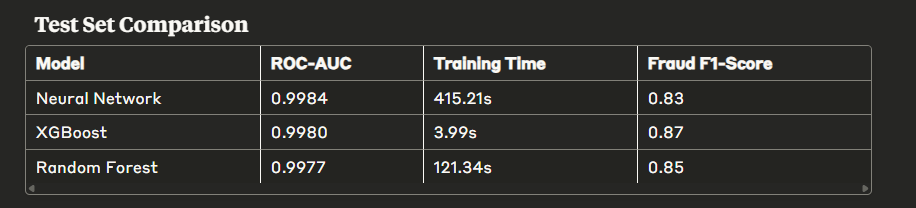

###Fraud Detection Performance

XGBoost: Best balanced performance (87% precision, 86% recall)
Neural Network: Highest recall (95%) but lower precision (73%)
Random Forest: Moderate balance (83% precision, 86% recall)

###Conclusions
All models demonstrated exceptional fraud detection capabilities with >99% accuracy. XGBoost emerged as optimal for production deployment, offering the best combination of predictive performance (ROC-AUC = 0.9980), computational efficiency (104× faster than neural networks), and balanced fraud detection (F1 = 0.87). The study validates ensemble approaches with proper sampling techniques for addressing financial fraud detection challenges.

Key Findings: Class imbalance treatment and ensemble methods enable highly effective fraud detection, with XGBoost providing superior operational characteristics for real-world applications.